# MICrONS Explorer: Fields Stats

Useful links:<br />
[Matched Cells Functional Data](https://github.com/cajal/microns_phase3_nda/blob/v8/tutorial_notebooks/Matched_Cell_Functional_Data.ipynb)<br />
[DataJoint Introduction](https://github.com/datajoint/microns_phase3_nda/blob/main/tutorial_notebooks/Using_DataJoint_to_Access_Functional_Data.ipynb)<br />
[Dataset Structure](https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/functional_data/two_photon_processed_data_and_metadata/database_v8/two_photon_processed_data_and_metadata_technical_documentation_v8.pdf)<br />
[Technical documentation for the database](https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/functional_data/two_photon_processed_data_and_metadata/database_v8/two_photon_processed_data_and_metadata_technical_documentation_v8.pdf)

## Import packages

In [1]:
! pip install datajoint==0.12.9 caveclient==5.7.0 em_coregistration@git+https://github.com/AllenInstitute/em_coregistration@phase3#egg=em_coregistration

  Cloning https://github.com/AllenInstitute/em_coregistration (to revision phase3) to /private/var/folders/g0/db_6133s4c72c83lmc3808m40000gn/T/pip-install-l_dk0oxe/em-coregistration_b74f8abaeb524bf28d518d967de9ee84
  Running command git clone --filter=blob:none --quiet https://github.com/AllenInstitute/em_coregistration /private/var/folders/g0/db_6133s4c72c83lmc3808m40000gn/T/pip-install-l_dk0oxe/em-coregistration_b74f8abaeb524bf28d518d967de9ee84
  Running command git checkout -b phase3 --track origin/phase3
  Switched to a new branch 'phase3'
  branch 'phase3' set up to track 'origin/phase3'.
  Resolved https://github.com/AllenInstitute/em_coregistration to commit bc40b2ae89523538a5d39afdedaad9e1887cbd68
  Preparing metadata (setup.py) ... done


In [2]:
import datajoint as dj
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

from caveclient import CAVEclient
from dotenv import load_dotenv
from getpass import getpass
from pathlib import Path
from tqdm import tqdm

## Setup environment variables

In [3]:
env_variables = [
  'DJ_HOST',
  'DJ_USER',
  'DJ_PASS',

  'CAVE_TOKEN',
]

load_dotenv()

for key in env_variables:
  value = os.getenv(key)

  if value is None:
    value = getpass(key)

  os.environ[key] = value

## Suppress warnings

In [4]:
warnings.filterwarnings('ignore')

## Define local database credentials

Instructions for using the local database are available at https://github.com/cajal/microns-nda-access.

In [5]:
dj.config['database.host'] = os.getenv('DJ_HOST')
dj.config['database.user'] = os.getenv('DJ_USER')
dj.config['database.password'] = os.getenv('DJ_PASS')
from microns_phase3 import nda, utils

Connecting root@localhost:3306


## Define target FPS

In [6]:
target_fps = 15

## Define CAVE token

In [7]:
cave_token = os.getenv('CAVE_TOKEN')

In [8]:
def fetch_coregistration_manual_dataset(version=4):
  dataset_name = f'coregistration_manual_v{version}'
  filename = f'{dataset_name}.csv'

  if os.path.exists(filename):
    return pd.read_csv(filename)
  else:
    client = CAVEclient()
    client.auth.save_token(cave_token, overwrite=True)
    client = CAVEclient('minnie65_public')
    latest_materialize_version = max(client.materialize.get_versions())
    client.materialize.version = latest_materialize_version
    matched_df = client.materialize.query_table('coregistration_manual_v4')
    matched_df.to_csv(filename)
    return matched_df

In [9]:
coregistration_manual_df = fetch_coregistration_manual_dataset()
coregistration_manual_df

,Unnamed: 0,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,score,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,0,13337,2024-05-21 18:42:40.725320+00:00,t,582276,7,5,4909,4,6.10722,9.56868,582276,2020-09-28 22:41:42.536121+00:00,t,274.291589,111332012547320963,864691135738685297,[338720 125232 19589],[nan nan nan],[nan nan nan]
1,1,12542,2024-05-21 18:42:40.285576+00:00,t,194144,7,4,9575,6,8.55708,-0.71490,194144,2020-09-28 22:42:01.511773+00:00,t,213.307228,83542405709639148,864691135614842827,[136400 170640 17951],[nan nan nan],[nan nan nan]
2,2,15097,2024-05-21 18:42:41.703496+00:00,t,194144,8,5,8632,6,4.25055,7.87525,194144,2020-09-28 22:42:01.511773+00:00,t,213.307228,83542405709639148,864691135614842827,[136400 170640 17951],[nan nan nan],[nan nan nan]
3,3,12829,2024-05-21 18:42:40.443453+00:00,t,517966,7,5,1526,2,5.82370,4.16608,517966,2020-09-28 22:41:48.288009+00:00,t,313.318932,107530794289274882,864691136966116814,[310944 115888 16752],[nan nan nan],[nan nan nan]
4,4,18299,2024-05-21 18:42:43.440278+00:00,t,293318,9,4,8066,6,5.63758,8.91502,293318,2020-09-28 22:45:23.572432+00:00,t,430.108180,90783515419343652,864691135502985397,[189472 119296 26037],[nan nan nan],[nan nan nan]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19176,19176,14125,2024-05-21 18:42:41.164297+00:00,t,294539,8,5,2740,2,4.80801,0.93167,294539,2020-09-28 22:45:19.090364+00:00,t,367.674819,89659676492660967,864691135938604804,[181216 134624 21266],[nan nan nan],[nan nan nan]
19177,19177,17380,2024-05-21 18:42:42.943521+00:00,t,256736,9,4,2582,2,3.01300,9.97050,256736,2020-09-28 22:45:09.951016+00:00,t,330.874880,88461140300269012,864691135988461315,[172128 117536 22828],[nan nan nan],[nan nan nan]
19178,19178,19051,2024-05-21 18:42:43.850747+00:00,t,422857,9,6,4965,4,7.72988,5.88402,422857,2020-09-28 22:43:49.418248+00:00,t,328.749711,99932345649552731,864691135867970070,[255616 126112 26776],[nan nan nan],[nan nan nan]
19179,19179,1182,2024-05-21 18:38:22.960868+00:00,t,302957,4,7,7908,8,5.59223,8.69387,302957,2020-09-28 22:44:02.400990+00:00,t,507.260273,90020659837046869,864691135585266808,[183456 202752 20953],[nan nan nan],[nan nan nan]


In [10]:
coregistration_manual_df.columns

Index(['Unnamed: 0', 'id', 'created', 'valid', 'target_id', 'session',
       'scan_idx', 'unit_id', 'field', 'residual', 'score', 'id_ref',
       'created_ref', 'valid_ref', 'volume', 'pt_supervoxel_id', 'pt_root_id',
       'pt_position', 'bb_start_position', 'bb_end_position'],
      dtype='object')

In [11]:
def get_field_mask(field_key):
  corr, avg = (nda.SummaryImages & field_key).fetch1('correlation', 'average')
  return corr * avg

In [12]:
def plot_field(field_key):
  plot_path = f'./fields/session_{field_key["session"]}_scan_{field_key["scan_idx"]}_field_{field_key["field"]}.png'

  if os.path.exists(plot_path):
    return

  masks_df = pd.DataFrame(nda.Segmentation * nda.MaskClassification * nda.ScanUnit & field_key & {'mask_type': 'soma'})
  masks = utils.get_all_masks(field_key, mask_type='soma')
  field_mask = get_field_mask(field_key)
  image_height, image_width, num_masks = masks.shape
  figsize = np.array([image_width, image_height]) / min(image_height, image_width)
  figure = plt.figure(figsize=figsize * 7)
  plt.imshow(field_mask)

  cumsum_mask = np.empty([image_height, image_width])
  for i in range(num_masks):
    mask_row = masks_df.iloc[i]
    mask = masks[:, :, i]

    ## Compute cumulative mass (similar to caiman)
    indices = np.unravel_index(
      np.flip(np.argsort(mask, axis=None), axis=0), mask.shape
    )  # max to min value in mask
    cumsum_mask[indices] = np.cumsum(mask[indices] ** 2) / np.sum(mask ** 2)

    ## Plot contour at desired threshold (with random color)
    random_color = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.contour(cumsum_mask, [0.97], linewidths=0.8, colors=[random_color])
    plt.scatter([mask_row['px_x']], [mask_row['px_y']], c=random_color, s=2)

  figure.savefig(plot_path)

In [13]:
def combine_images(pieces, centers):
  # Determine the size of the final image
  min_x = min(center[0] - piece.shape[1] // 2 for piece, center in zip(pieces, centers))
  max_x = max(center[0] + piece.shape[1] // 2 for piece, center in zip(pieces, centers))
  min_y = min(center[1] - piece.shape[0] // 2 for piece, center in zip(pieces, centers))
  max_y = max(center[1] + piece.shape[0] // 2 for piece, center in zip(pieces, centers))

  # Calculate the dimensions of the final image
  width = int(max_x - min_x)
  height = int(max_y - min_y)

  # Create an empty array filled with black pixels
  final_image = np.zeros((height, width), dtype=np.uint8)

  # Place each piece in the correct position
  for piece, (center_x, center_y) in zip(pieces, centers):
    piece_height, piece_width = piece.shape
    start_x = int(center_x - piece_width // 2 - min_x)
    start_y = int(center_y - piece_height // 2 - min_y)
    final_image[start_y:start_y + piece_height, start_x:start_x + piece_width] = piece

  return final_image, min_x, min_y

In [14]:
def plot_scan(scan_key):
  scan_fields_df = pd.DataFrame(nda.Field & scan_key)

  field_masks = {}
  field_centers = {}
  field_keys = {}

  for row_idx, field_row in scan_fields_df.iterrows():
    field_idx = int(field_row['field'])
    field_key = {**scan_key, 'field': field_idx}
    field_z = field_row['field_z']

    if field_z not in field_masks:
      field_masks[field_z] = []
    if field_z not in field_centers:
      field_centers[field_z] = []
    if field_z not in field_keys:
      field_keys[field_z] = []

    field_center = (field_row['field_x'] / 2.5, field_row['field_y'] / 2.5)
    field_centers[field_z].append(field_center)

    field_mask = get_field_mask(field_key)
    field_masks[field_z].append(field_mask)

    field_keys[field_z].append(field_key)

  for z in field_masks.keys():
    plot_path = f'./fields/session_{scan_key["session"]}_scan_{scan_key["scan_idx"]}_z_{z}.png'

    if os.path.exists(plot_path):
      return

    field_masks_z = field_masks[z]
    field_centers_z = field_centers[z]
    field_keys_z = field_keys[z]

    combined_image, min_x, min_y = combine_images(field_masks_z, field_centers_z)
    image_height, image_width = combined_image.shape
    figsize = np.array([image_width, image_height]) / min(image_height, image_width)
    figure = plt.figure(figsize=figsize * 7)
    plt.imshow(combined_image)

    figure.savefig(plot_path)

100%|██████████| 16/16 [10:50<00:00, 40.63s/it]


,session_idx,scan_idx,field_idx,px_width,px_height,um_width,um_height,um_center_x,um_center_y,um_center_z,masks_num,artifact_masks_num,soma_masks_num,is_preferred
0,4,7,1,248.0,440.0,620.0,1100.0,-485.0,-235.0,80.0,643,130,513,True
1,4,7,2,248.0,440.0,620.0,1100.0,95.0,-235.0,80.0,452,75,377,True
2,4,7,3,248.0,440.0,620.0,1100.0,-485.0,-235.0,220.0,1455,127,1328,True
3,4,7,4,248.0,440.0,620.0,1100.0,95.0,-235.0,220.0,1389,152,1237,True
4,4,7,5,248.0,440.0,620.0,1100.0,-485.0,-235.0,360.0,1420,99,1321,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,9,4,6,248.0,440.0,620.0,1100.0,100.0,-215.0,170.0,1400,102,1298,True
116,9,6,1,372.0,600.0,620.0,1000.0,-480.0,-215.0,155.0,1361,101,1260,True
117,9,6,2,372.0,600.0,620.0,1000.0,100.0,-215.0,155.0,1362,86,1276,True
118,9,6,3,372.0,600.0,620.0,1000.0,-480.0,-215.0,175.0,1369,99,1270,True


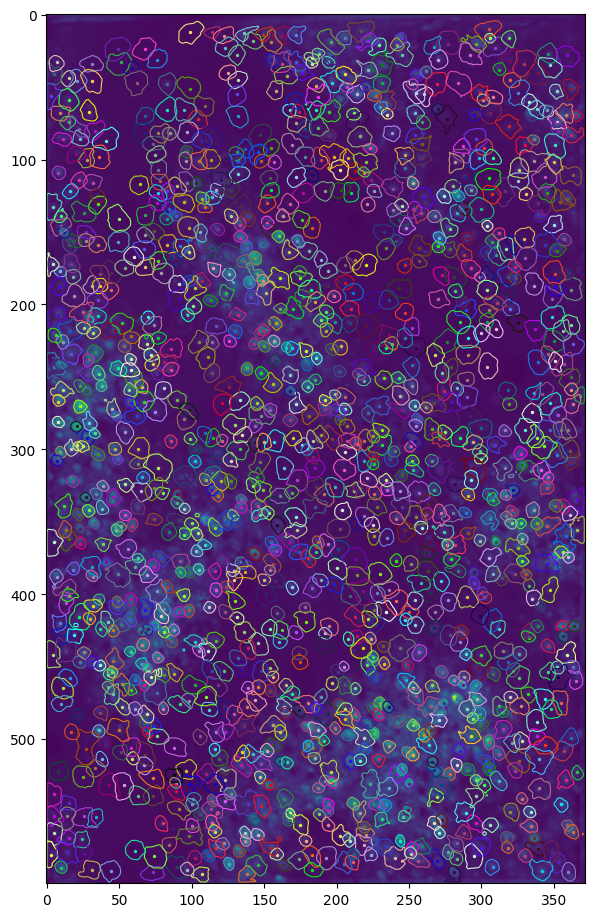

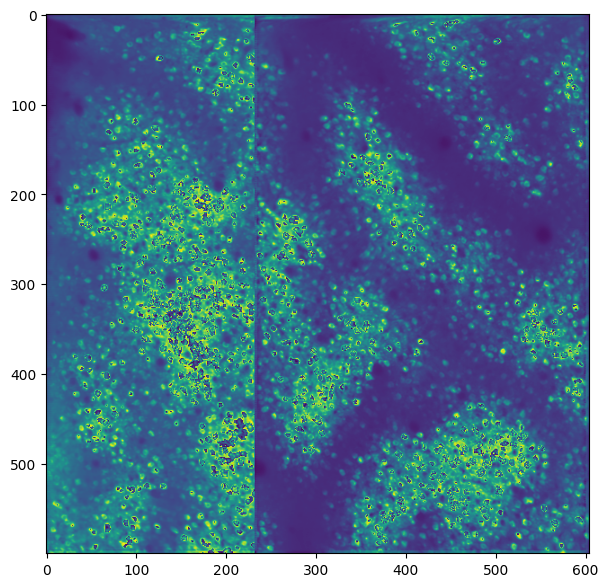

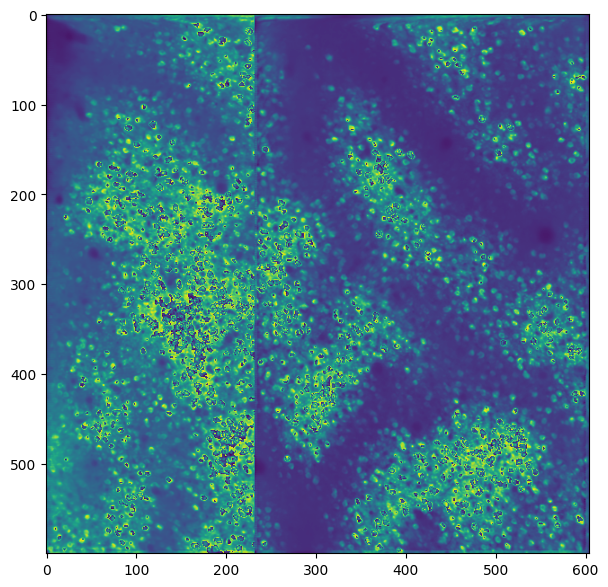

In [15]:
grouped_df = coregistration_manual_df.groupby(['session', 'scan_idx'])
fields_df = pd.DataFrame()

for (session_idx, scan_idx), group_df in tqdm(grouped_df):
  scan_key = {'session': session_idx, 'scan_idx': scan_idx}

  scan_fields_df = pd.DataFrame(nda.Field & scan_key)
  scan_include_df = pd.DataFrame(nda.ScanInclude & scan_key)

  px_pieces = {}
  field_centers = {}
  masks_df_list = {}

  for field_index, field_row in scan_fields_df.iterrows():
    field_idx = int(field_row['field'])
    field_key = {'session': session_idx, 'scan_idx': scan_idx, 'field': field_idx}

    masks_df = pd.DataFrame(nda.Segmentation * nda.MaskClassification * nda.ScanUnit & field_key)

    result_field_row = pd.DataFrame({
      'session_idx': session_idx,
      'scan_idx': scan_idx,
      'field_idx': field_idx,
      'px_width': field_row['px_width'],
      'px_height': field_row['px_height'],
      'um_width': field_row['um_width'],
      'um_height': field_row['um_height'],
      'um_center_x': field_row['field_x'],
      'um_center_y': field_row['field_y'],
      'um_center_z': field_row['field_z'],
      'masks_num': len(masks_df),
      'artifact_masks_num': len(masks_df[masks_df['mask_type'] == 'artifact']),
      'soma_masks_num': len(masks_df[masks_df['mask_type'] == 'soma']),
      'is_preferred': bool(len(scan_include_df)),
    }, index=[0])
    fields_df = pd.concat([fields_df, result_field_row], ignore_index=True)

    plot_field(field_key)

  plot_scan(scan_key)

fields_df.to_csv('./fields/fields.csv')

fields_df
